# Performance Testing for LogRegNN (Gradient Descent and BFGS)

In [29]:
using NBInclude
using StatPlots
@nbinclude("Iris_Binary.ipynb");
@nbinclude("Visualization.ipynb");
@nbinclude("LogRegNN.ipynb");
@nbinclude("BFGS_LBFGS.ipynb");

In [30]:
X, Y = get_binary_iris();

In [31]:
function accuracy(A, B) return sum(A .== B)/length(A) end;

### Running Gradient Descent 100 times from zero and take average result (no. of iterations, error, time, bytes)

In [32]:
function LogRegNN_performance( fun, iter_index; count_accuracy=false )
    
    accuracy_history = []
    timed_history = []
    for j in 1:SAMPLES
        timed = @timed fun()
        push!(timed_history, timed)
#         println(timed)        
        if count_accuracy
            pred = timed.value[2]
            push!(accuracy_history, accuracy(pred, Y))
        end
    end
    
    mean_iters = sum(map(h->h.value[iter_index], timed_history))/SAMPLES
    mean_error = sum(map(h->last(h.value[1]), timed_history))/SAMPLES
    mean_exec_time = sum(map(h->h.time, timed_history))/SAMPLES
    mean_alloc_bytes = sum(map(h->h.bytes, timed_history))/SAMPLES
    mean_accuracy = count_accuracy==true ? sum(accuracy_history)/SAMPLES : nothing
    return Dict(
        "mean_accuracy" => mean_accuracy,
        "mean_iters" => mean_iters,
        "mean_error" => mean_error,
        "mean_exec_time" => mean_exec_time,
        "mean_alloc_bytes" => mean_alloc_bytes )
end;

In [33]:
""" Network Parameters """
α = 0.001; ITERS = 200; λ = 0.005;
range = -0.01:0.001:0.01
HIDDEN_SIZE = 2;

In [34]:
W1 = rand(range, 2, HIDDEN_SIZE )
b1 = zeros((1, HIDDEN_SIZE))
W2 = rand(range, HIDDEN_SIZE, 1 )
b2 = 0.0;

In [35]:
gd = () -> train_LogRegNN_GD( W1, b1, W2, b2, ITERS, α, λ, Y; max_error=ERROR );

In [36]:
""" Testing Early Stop """
SAMPLES = 100;
ERROR = 10e-2;
gd_timed = LogRegNN_performance( gd, 8; count_accuracy=true )

Dict{String,Float64} with 5 entries:
  "mean_error"       => 0.0
  "mean_exec_time"   => 0.0253623
  "mean_accuracy"    => 0.97
  "mean_alloc_bytes" => 2.46424e6
  "mean_iters"       => 107.0

In [37]:
""" Testing Small Threshold """
SAMPLES = 100;
ERROR = 10e-4;
gd_timed = LogRegNN_performance( gd, 8; count_accuracy=true )

Dict{String,Float64} with 5 entries:
  "mean_error"       => 0.0448626
  "mean_exec_time"   => 0.0106656
  "mean_accuracy"    => 1.0
  "mean_alloc_bytes" => 3.98704e6
  "mean_iters"       => 200.0

### Running BFGS 100 times with lucky weights (no freeze)

In [38]:
# These weights DON'T cause BFGS freeze
W2 = reshape([0.01; -0.01], (2,1))
W1 = [0.001 -0.01; 0.006 -0.009]
b2 = 0.01
b1 = [0.01 0.01];

In [39]:
ITERS = 6;

In [40]:
bfgs = () -> train_LogRegNN_BFGS(
    Dict("W1"=>[W1], "b1"=>[b1], "W2"=>[W2], "b2"=>[b2]), ITERS; v=false );

In [41]:
bfgs_timed = LogRegNN_performance( bfgs, 2 )

Dict{String,Union{Nothing, Float64}} with 5 entries:
  "mean_error"       => 0.526905
  "mean_exec_time"   => 0.0171804
  "mean_accuracy"    => nothing
  "mean_alloc_bytes" => 5.06938e6
  "mean_iters"       => 6.0

### Running L-BFGS 100 times with lucky weights (L-BFGS doesn't freeze)

In [42]:
ITERS = 20; m = 4;

In [43]:
lbfgs = () -> train_LogRegNN_LBFGS(
    Dict("W1"=>[W1], "b1"=>[b1], "W2"=>[W2], "b2"=>[b2]), ITERS, m; v=false );

In [44]:
lbfgs_timed = LogRegNN_performance( lbfgs, 2 )

Dict{String,Union{Nothing, Float64}} with 5 entries:
  "mean_error"       => 0.665765
  "mean_exec_time"   => 0.0323217
  "mean_accuracy"    => nothing
  "mean_alloc_bytes" => 1.6161e7
  "mean_iters"       => 20.0

### Plotting

In [45]:
measures = [gd_timed, bfgs_timed, lbfgs_timed];

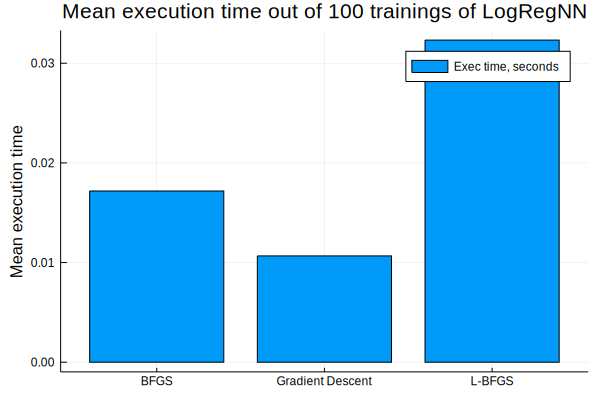

In [46]:
plt = groupedbar(
    ["Gradient Descent", "BFGS", "L-BFGS"], 
    [d["mean_exec_time"] for d in measures],
    group=repeat(["Exec time, seconds"], inner = 3),
    ylabel="Mean execution time",
    title="Mean execution time out of 100 trainings of LogRegNN",
)
savefig(plt, "network_plots/time.pdf")
plt

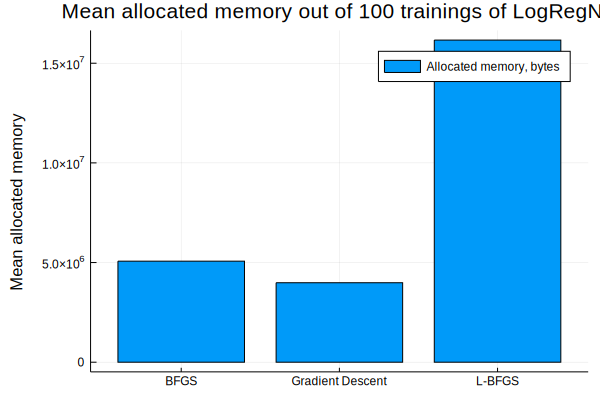

In [47]:
plt = groupedbar(
    ["Gradient Descent", "BFGS", "L-BFGS"], 
    [d["mean_alloc_bytes"] for d in measures],
    group=repeat(["Allocated memory, bytes"], inner = 3),
    ylabel="Mean allocated memory",
    title="Mean allocated memory out of 100 trainings of LogRegNN",
)
savefig(plt, "network_plots/memory.pdf")
plt

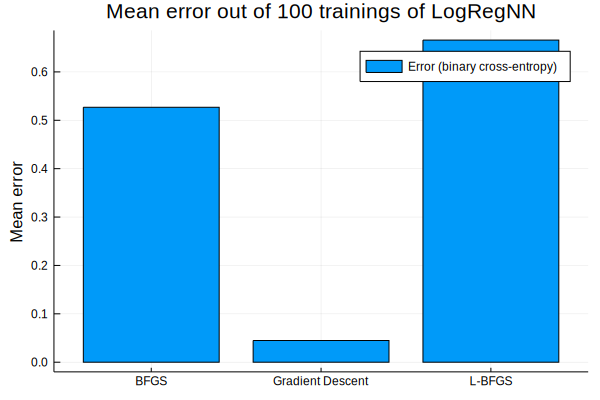

In [48]:
plt = groupedbar(
    ["Gradient Descent", "BFGS", "L-BFGS"], 
    [d["mean_error"] for d in measures],
    group=repeat(["Error (binary cross-entropy)"], inner = 3),
    ylabel="Mean error",
    title="Mean error out of 100 trainings of LogRegNN",
)
savefig(plt, "network_plots/error.pdf")
plt